# VGG19 network using slim

* Prerequisites
  * `git clone https://github.com/tensorflow/models.git`
  * [Pretrained models](https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models)
  
* Add path to system enviornment
```bash
export PYTHONPATH="$HOME/models/research/slim/:$PYTHONPATH"
```
* or use `sys.path.append` like below

In [1]:
import os
import sys
# put your tensorflow "models" absolute path
#sys.path.append("/Users/ilguyi/models/research/slim")

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load a VGG19 graph

In [2]:
from nets import vgg
# When you don't have a tensorflow models folder, use below syntax
#from tensorflow.contrib.slim.nets import vgg

In [3]:
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])

In [4]:
with slim.arg_scope(vgg.vgg_arg_scope()):
  logits, end_points = vgg.vgg_19(inputs, num_classes=1000, is_training=False)

In [5]:
print(logits)

Tensor("vgg_19/fc8/squeezed:0", shape=(?, 1000), dtype=float32)


In [6]:
for node in end_points:
  print(node)

vgg_19/conv1/conv1_1
vgg_19/conv1/conv1_2
vgg_19/pool1
vgg_19/conv2/conv2_1
vgg_19/conv2/conv2_2
vgg_19/pool2
vgg_19/conv3/conv3_1
vgg_19/conv3/conv3_2
vgg_19/conv3/conv3_3
vgg_19/conv3/conv3_4
vgg_19/pool3
vgg_19/conv4/conv4_1
vgg_19/conv4/conv4_2
vgg_19/conv4/conv4_3
vgg_19/conv4/conv4_4
vgg_19/pool4
vgg_19/conv5/conv5_1
vgg_19/conv5/conv5_2
vgg_19/conv5/conv5_3
vgg_19/conv5/conv5_4
vgg_19/pool5
vgg_19/fc6
vgg_19/fc7
vgg_19/fc8


In [7]:
with tf.Session() as sess:
  writer = tf.summary.FileWriter("./graphs/08.vgg19.slim", sess.graph)
  writer.close()

### Download the VGG19 checkpoint: 

```
$ CHECKPOINT_DIR='../../checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/vgg_19_2016_08_28.tar.gz
$ tar -xvf vgg_19_2016_08_28.tar.gz
$ mv vgg_19.ckpt ${CHECKPOINT_DIR}
$ rm vgg_19_2016_08_28.tar.gz
```

In [8]:
# Download the VGG19 checkpoint: 
# if you already have a vgg_19.ckpt then skip and comment below commands
#!mkdir ../../checkpoints
#!wget http://download.tensorflow.org/models/vgg_19_2016_08_28.tar.gz
#!tar -xvf vgg_19_2016_08_28.tar.gz
#!mv vgg_19.ckpt ../../checkpoints
#!rm vgg_19_2016_08_28.tar.gz
#print('done')

### Restore VGG19 weights using `tf.saver.restore`

#### Read a image

In [9]:
def vgg_preprocessing(image):
  """image preprocessing

  Args:
    image (PIL image): image with shape [height, width, channels]
    
  Returns:
    image (np.float32): vgg preprocessed image with 4-rank tensor shape [1, height, width, channels] applied by mean_image_subtraction
  """
  norm_means = np.array([123.68, 116.779, 103.939])
  vgg_image_size = 224
  image = image.resize((vgg_image_size, vgg_image_size))
  image = np.asarray(image)
  image = image.astype(np.float32)
  image -= norm_means
  
  return image

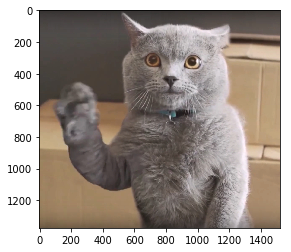

In [10]:
my_image = Image.open('../../input_data/cat2.jpg')
plt.imshow(my_image)

In [11]:
my_image = vgg_preprocessing(my_image)
my_image = np.expand_dims(my_image, axis=0)

In [12]:
saver = tf.train.Saver()

with tf.Session(config=sess_config) as sess:

  # use saver object to load variables from the saved model
  saver.restore(sess, "../../checkpoints/vgg_19.ckpt")
  
  # print conv1_1 weight itself
  conv1_1_w = sess.run(tf.trainable_variables()[0])
  
  # print feature maps
  conv1_1, conv2_1, \
  conv3_2, conv4_3, \
  conv5_3 = sess.run([end_points['vgg_19/conv1/conv1_1'],
                      end_points['vgg_19/conv2/conv2_1'],
                      end_points['vgg_19/conv3/conv3_2'],
                      end_points['vgg_19/conv4/conv4_3'],
                      end_points['vgg_19/conv5/conv5_3']],
                     feed_dict={inputs: my_image})

INFO:tensorflow:Restoring parameters from ../../checkpoints/vgg_19.ckpt


### Print feature maps

In [13]:
def print_all_feature_maps(layer, layer_name):
  """Print all feature maps
    This code is borrowed from "Deep Learning with Python" (by F. Chollet)
  
  Args:
    layer (4-rank Tensor): feature maps
    layer_name (string): name of feature maps
    
  Returns:
    print all feature maps
  """
  num_features = layer.shape[-1]
  size = layer.shape[1]
  images_per_row = 16
  for feature_map in range(num_features):
    num_cols = num_features // images_per_row
    display_grid = np.zeros((size * num_cols, images_per_row * size))

    for col in range(num_cols):
      for row in range(images_per_row):
        channel_image = layer[0,:,:,col * images_per_row + row]

        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Print feature maps of conv1_1

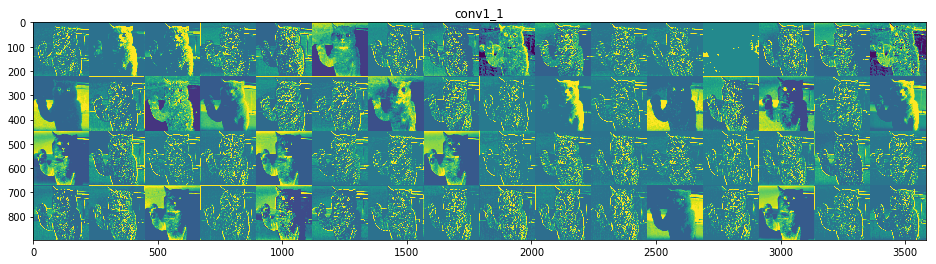

In [14]:
print_all_feature_maps(conv1_1, 'conv1_1')

### Print feature maps of conv2_1

/home/lab4all/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


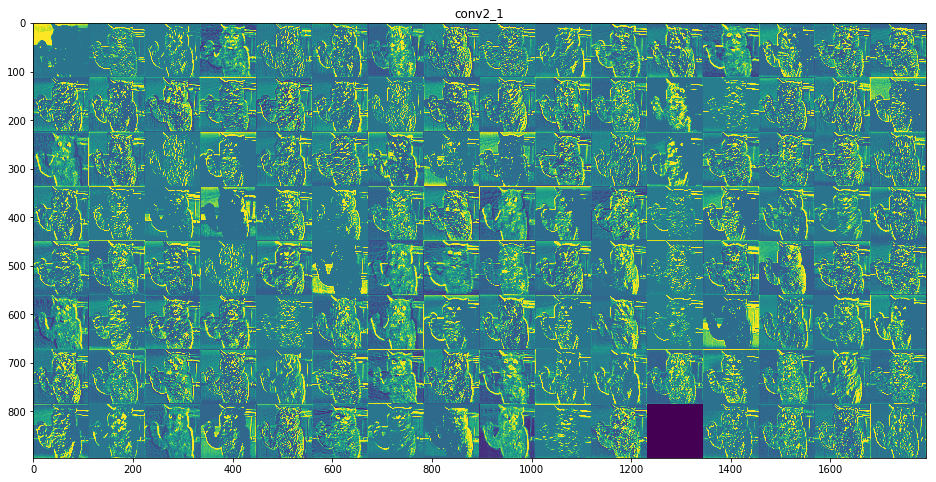

In [15]:
print_all_feature_maps(conv2_1, 'conv2_1')

### Print feature maps of conv3_2

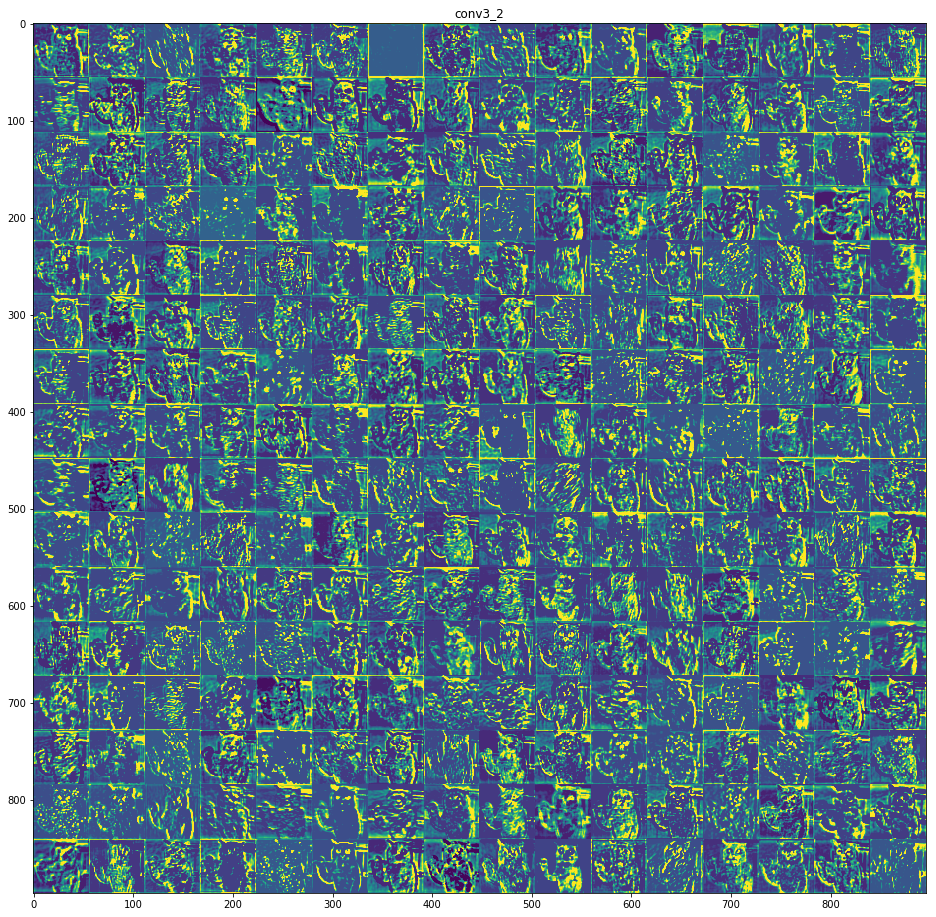

In [16]:
print_all_feature_maps(conv3_2, 'conv3_2')

### Print feature maps of conv4_3

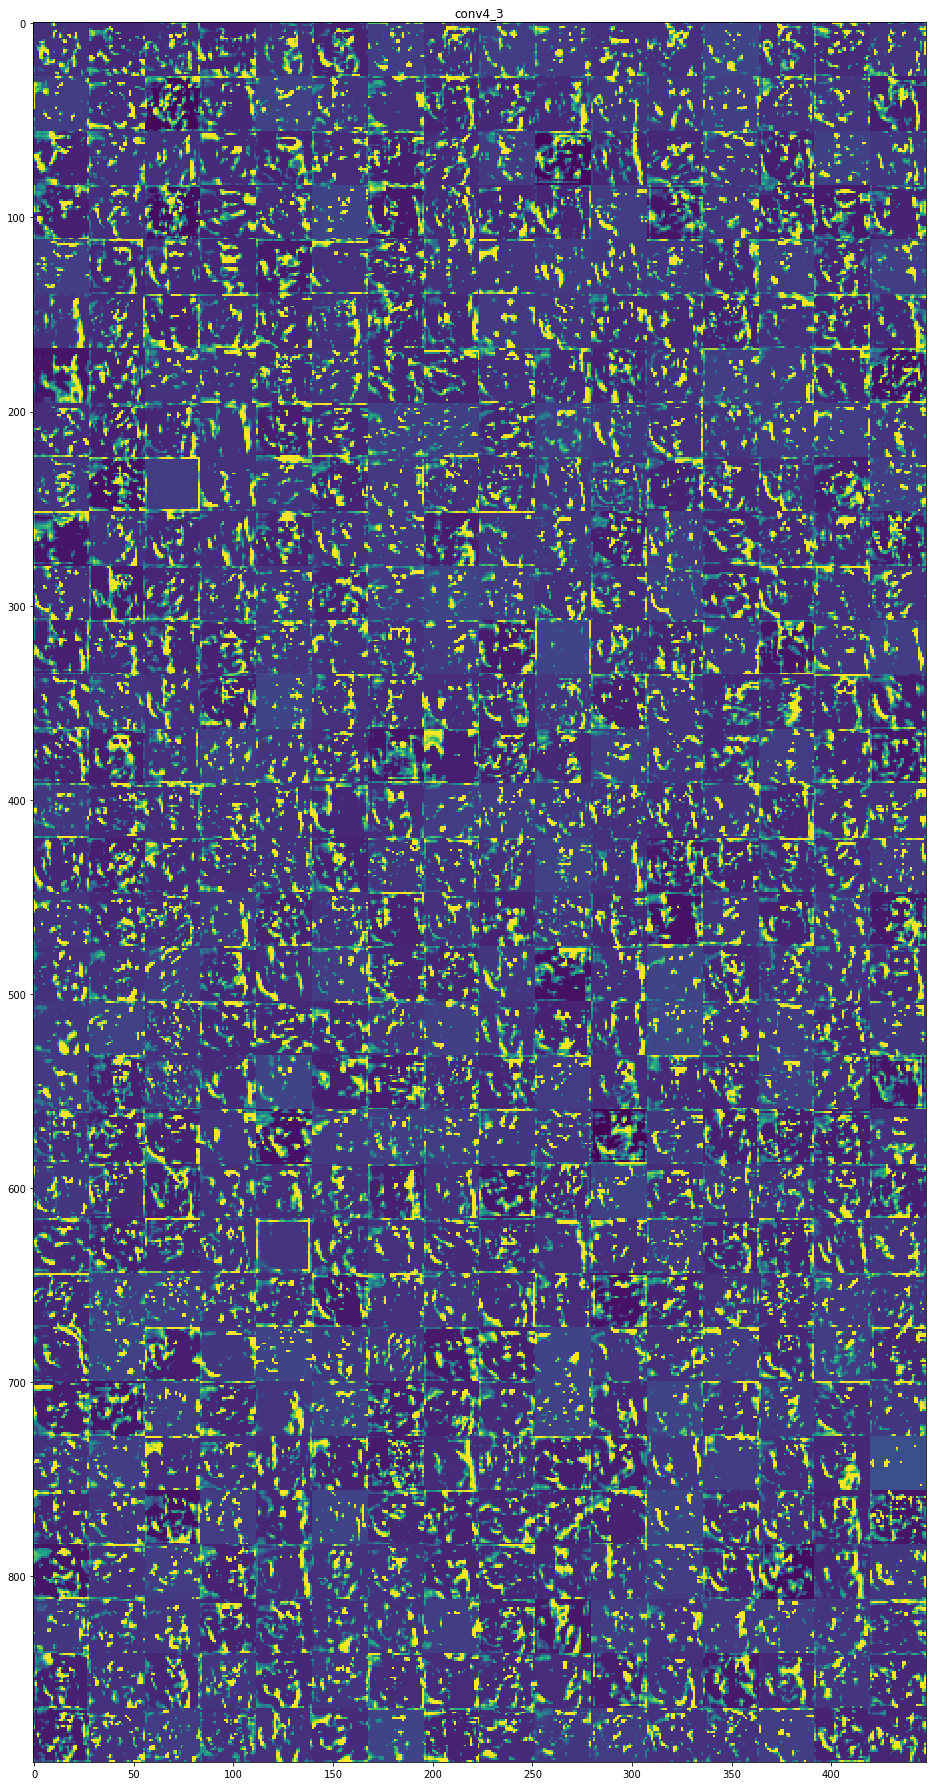

In [17]:
print_all_feature_maps(conv4_3, 'conv4_3')

### Print feature maps of conv5_3

/home/lab4all/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


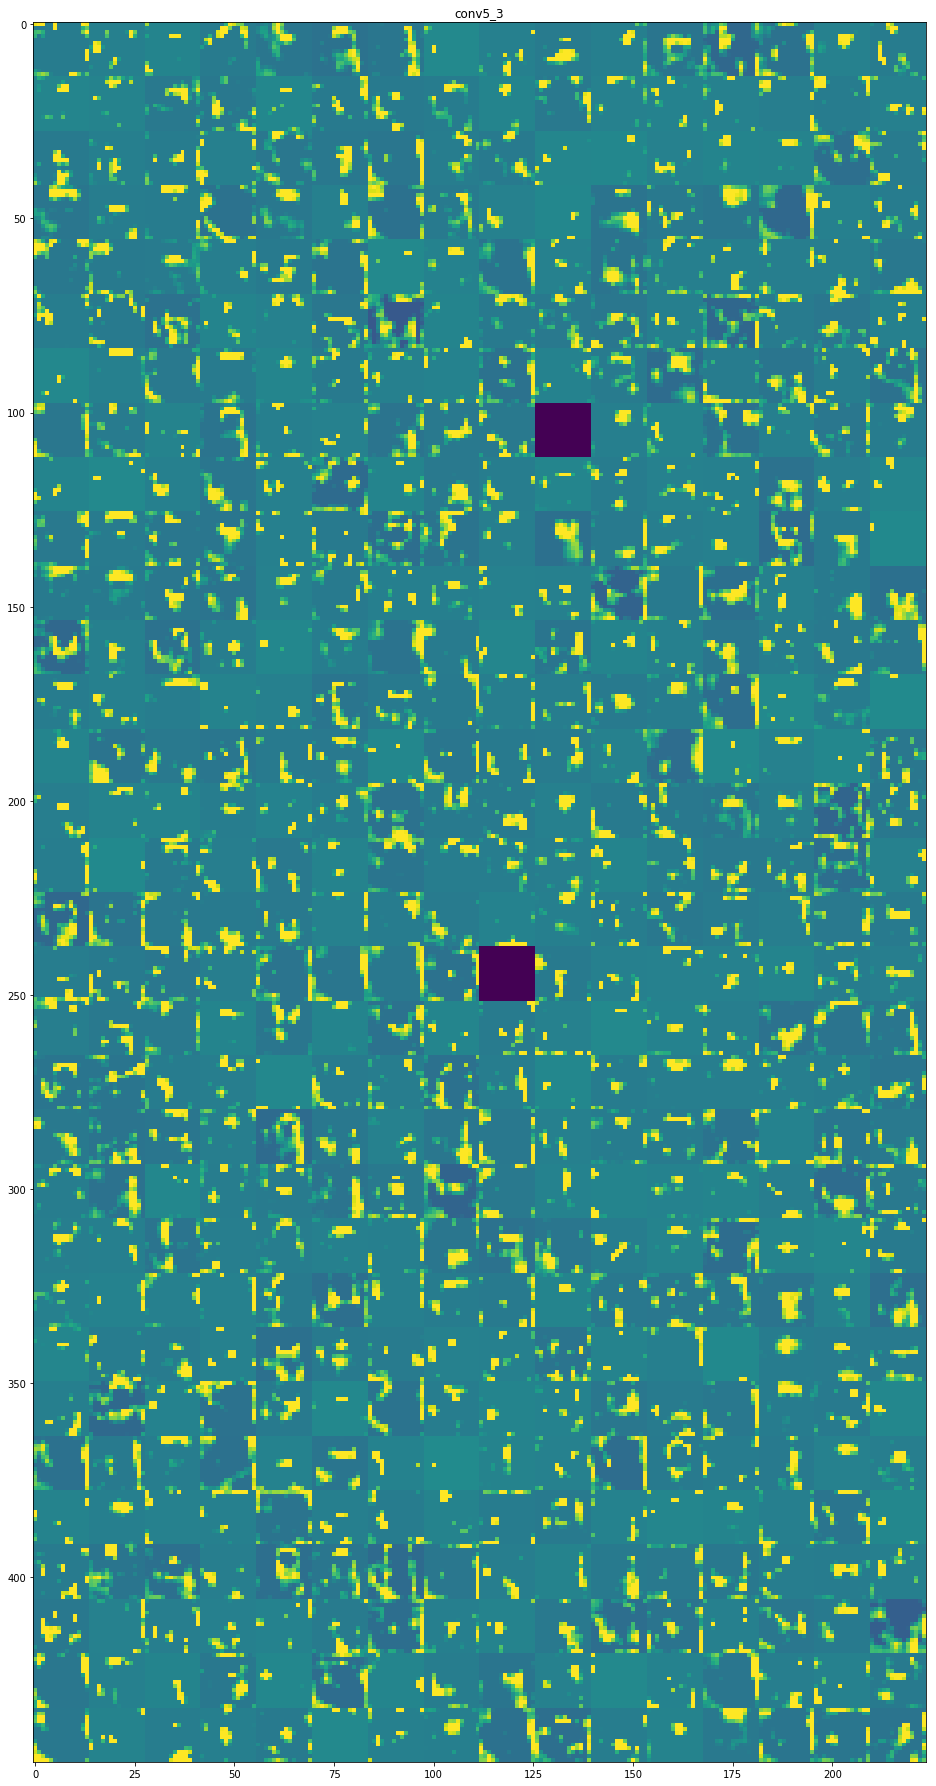

In [18]:
print_all_feature_maps(conv5_3, 'conv5_3')